## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Зоткин Владимир Владимирович

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 16 октября.


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [16]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [17]:
images_train, labels_train = next(iter(train_loader))

In [18]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

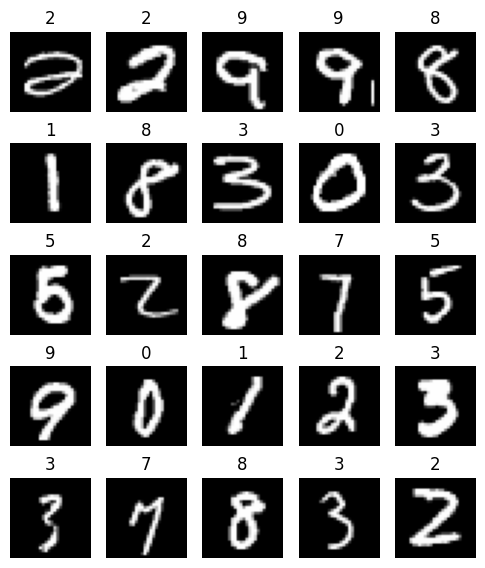

In [19]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [20]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [21]:
# layer_1 = nn.Linear(28*28, 500)
# layer_2 = nn.Linear(500, 10)

# layer_1.register_forward_hook(forward_hook)
# layer_2.register_forward_hook(forward_hook)

# layer_1.register_backward_hook(backward_hook)
# layer_2.register_backward_hook(backward_hook)

# init_layer(layer_1)
# init_layer(layer_2)

Соберем все вместе, используя ReLU в качестве функции активации:

In [22]:
# network = nn.Sequential(
#     layer_1,
#     nn.ReLU(),
#     layer_2
# )

#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

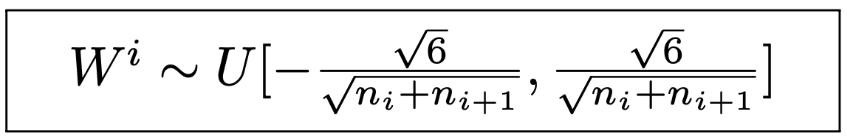

In [23]:
def train(model, optimizer, loss_fn=torch.nn.NLLLoss()):
    train_losses = []
    test_losses = []

    for epoch in range(10):
        model.train()
        losses = []
        for batch_idx, (images_train, labels_train) in enumerate(train_loader):
            optimizer.zero_grad()
            X = images_train.data
            y = labels_train.data
            output = model(X)
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(X), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

        train_losses.append(np.mean(losses))

        model.eval()
        losses = []
        for batch_idx, (images_test, labels_test) in enumerate(test_loader):
            X = images_test.data
            y = labels_test.data
            output = model(X)
            loss = loss_fn(output, y)

            losses.append(loss.item())

        print('Test Epoch: {}\tLoss: {:.6f}'.format(
                epoch, np.mean(losses)))
        test_losses.append(np.mean(losses))


    plt.plot(train_losses, label="Train Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(test_losses, label="Test Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.814961
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.288985
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.215088
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.217221
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.209675
Test Epoch: 0	Loss: 0.123565
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.137652
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.111633
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.092753
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.124540
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.171187
Test Epoch: 1	Loss: 0.094022
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.025584
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.048451
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.052019
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.046351
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.031176
Test Epoch: 2	Loss: 0.081208
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.028984
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.063907
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.081634
Train Epoch: 3 [38400/60000 (64%)

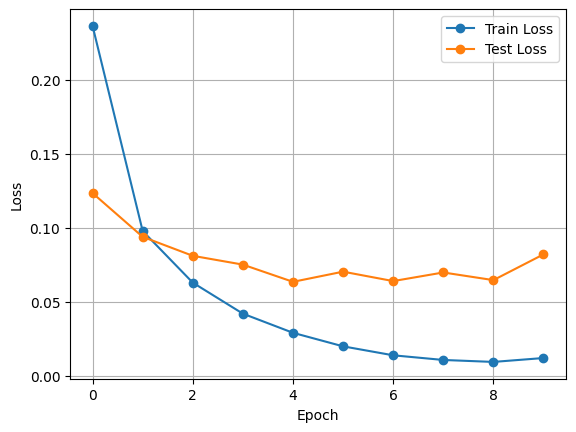

In [24]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

init_layer(layer_1, 0, np.sqrt(2 / (28 * 28 + 500)))
init_layer(layer_2, 0, np.sqrt(2 / (500 + 10)))

xavier_network = nn.Sequential(
    nn.Flatten(),
    layer_1,
    nn.Tanh(),
    layer_2,
    nn.LogSoftmax(1)
)

optimizer = torch.optim.Adam(xavier_network.parameters(), lr=0.001)
train(xavier_network, optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.302542
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.404309
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.188054
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.270011
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.170052
Test Epoch: 0	Loss: 0.137542
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.134158
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.068029
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.077042
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.147319
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.090307
Test Epoch: 1	Loss: 0.096016
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.018984
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.095335
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.060271
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.061842
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.062069
Test Epoch: 2	Loss: 0.085545
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.037258
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.069101
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.012542
Train Epoch: 3 [38400/60000 (64%)

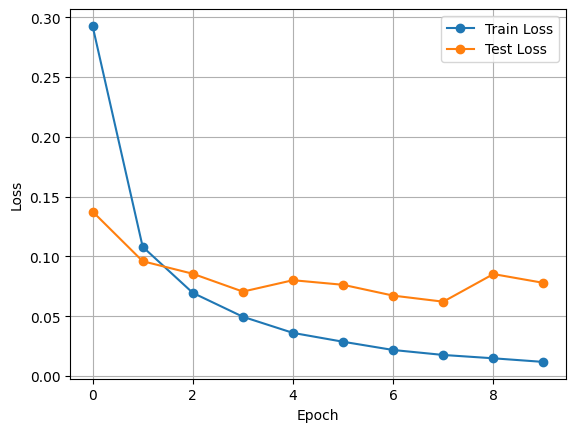

In [25]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

init_layer(layer_1, 0, 2 / (28 * 28))
init_layer(layer_2, 0, 2 / 500)

he_network = nn.Sequential(
    nn.Flatten(),
    layer_1,
    nn.ReLU(),
    layer_2,
    nn.LogSoftmax(1)
)

optimizer = torch.optim.Adam(he_network.parameters(), lr=0.001)
train(he_network, optimizer)

Графики loss-ов для этих двух сетей практически не отличаются

## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

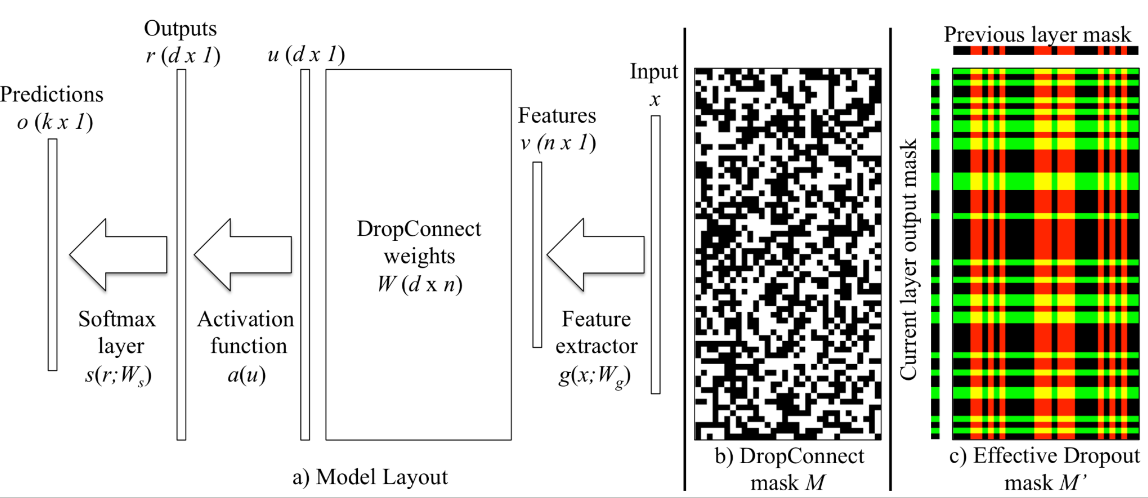

In [26]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.activation = nn.ReLU()  # В оригинальной статье усредняли активации на инференсе
        self.p = p

    def forward(self, x):
        if self.training:
            probas = torch.ones_like(self.linear.weight) * (1 - self.p)
            mask = torch.bernoulli(probas)
            mask.requires_grad_(False)
            output = F.linear(x, self.linear.weight * mask, self.linear.bias)
            return self.activation(output)
        else:
            Z = 1000
            W = self.linear.weight
            E_u = self.p * x @ W.T
            Var_u = self.p * (1 - self.p) * (x * x) @ (W * W).T

            mean_activation = 0

            for _ in range(Z):
                U = torch.normal(mean=E_u, std=torch.sqrt(Var_u))
                activation_U = self.activation(U)
                mean_activation += activation_U / Z

            return mean_activation

Основа для сети, которую будем обучать:

In [27]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

In [28]:
layers = [
    DropConnect(196, 128),
    nn.Linear(128, 10)
]

In [29]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)

Обучим получившуюся сеть:

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.320492
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.891351
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.525926
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.495467
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.400866
Test Epoch: 0	Loss: 0.306077
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.457592
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.241691
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.462722
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.369920
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.264205
Test Epoch: 1	Loss: 0.216135
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.288018
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.248678
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.275798
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.269608
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.218070
Test Epoch: 2	Loss: 0.164457
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.125846
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.267765
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.154859
Train Epoch: 3 [38400/60000 (64%)

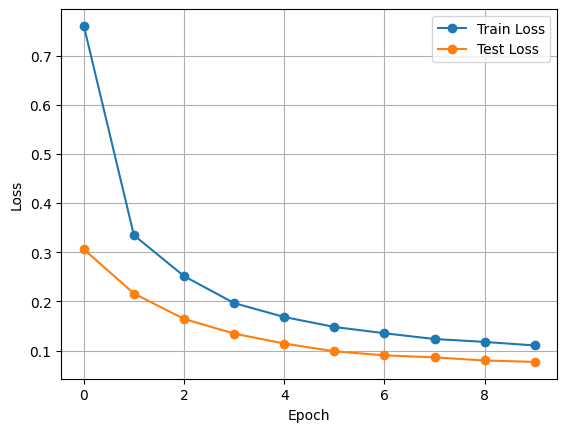

In [30]:
train(network, optimizer)


#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.305189
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.063672
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.605624
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.393867
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.322706
Test Epoch: 0	Loss: 0.173488
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.322717
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.388196
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.226199
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.280613
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.230333
Test Epoch: 1	Loss: 0.118906
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.254003
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.148155
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.144627
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.218592
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.299853
Test Epoch: 2	Loss: 0.099037
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.192637
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.165009
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.165213
Train Epoch: 3 [38400/60000 (64%)

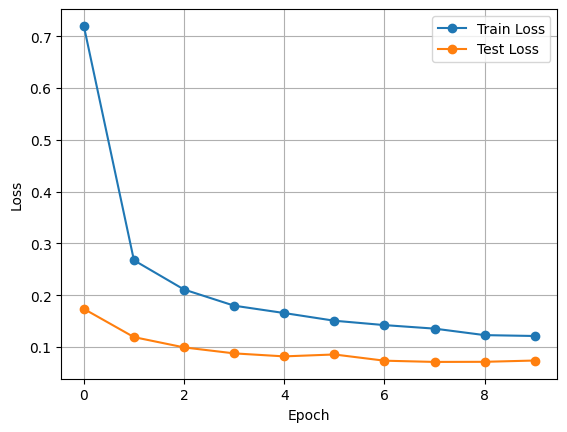

In [31]:
dropout_final = [
    nn.Linear(196, 128),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(128, 10)
]
dropout_net = TestNetwork(nn.Sequential(*dropout_final))
optimizer = torch.optim.Adam(dropout_net.parameters(), lr=0.001)
train(dropout_net, optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.305306
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.988486
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.528482
Train Epoch: 0 [38400/60000 (64%)]	Loss: 1.479872
Train Epoch: 0 [51200/60000 (85%)]	Loss: 1.011445
Test Epoch: 0	Loss: 0.741229
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.815710
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.593853
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.594243
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.323674
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.406181
Test Epoch: 1	Loss: 0.192289
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.295775
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.244027
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.433153
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.333641
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.246840
Test Epoch: 2	Loss: 0.148569
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.271018
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.260552
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.278810
Train Epoch: 3 [38400/60000 (64%)

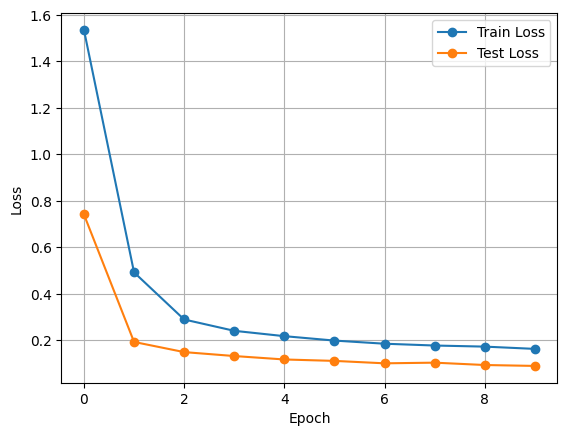

In [32]:
dropconnect_final = [
    DropConnect(196, 128),
    DropConnect(128, 128),
    DropConnect(128, 10)
]
dropconnect_net = TestNetwork(nn.Sequential(*dropconnect_final))
optimizer = torch.optim.Adam(dropconnect_net.parameters(), lr=0.001)
train(dropconnect_net, optimizer)

Loss при dropout-е получился ниже, чем на dropconnect. Это ожидаемо, потому что dropconnect это более сильная регуляризация. На графиках test loss все время меньше train loss, это связано с тем, что на тесте не используется отключение нейронов / весов.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

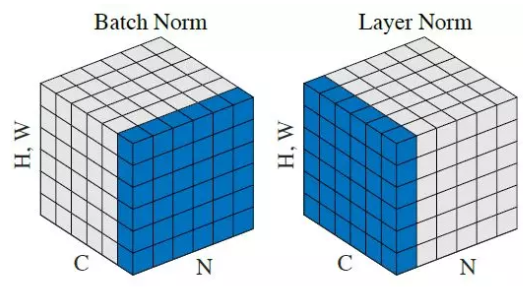

#### 3.1 Реализуйте Layer Normalization **(1 балл)**

In [34]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def forward(self, x):
        mean = x.mean(dim=-1, keepdims=True)
        var = x.var(dim=-1, keepdims=True, unbiased=False)

        gamma = torch.ones_like(x, requires_grad=True)
        betta = torch.zeros_like(x, requires_grad=True)

        output = gamma * ((x - mean) / torch.sqrt(var + 1e-8)) + betta
        return output

#### 3.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.332539
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.183378
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.169626
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.173465
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.184325
Test Epoch: 0	Loss: 0.083707
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.036835
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.072143
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.069497
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.107156
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.037832
Test Epoch: 1	Loss: 0.054857
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.026980
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.054850
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.049825
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.043667
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.027759
Test Epoch: 2	Loss: 0.052725
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.043273
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.023481
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.049389
Train Epoch: 3 [38400/60000 (64%)

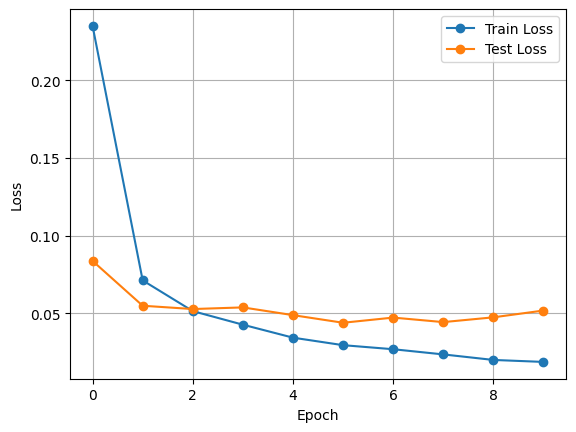

In [38]:
batchnorm_final = [
    nn.Linear(196, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 10)
]
batchnorm_net = TestNetwork(nn.Sequential(*batchnorm_final))
optimizer = torch.optim.Adam(batchnorm_net.parameters(), lr=0.001)
train(batchnorm_net, optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.453902
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.398978
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.257491
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.159413
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.114266
Test Epoch: 0	Loss: 0.119501
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.194467
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.083465
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.077040
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.105249
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.079925
Test Epoch: 1	Loss: 0.091077
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.125947
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.036762
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.060387
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.130244
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.104648
Test Epoch: 2	Loss: 0.076467
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.087521
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.062505
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.033070
Train Epoch: 3 [38400/60000 (64%)

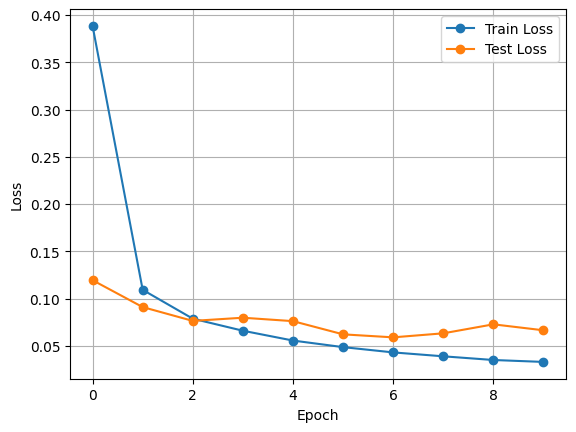

In [39]:
layernorm_final = [
    nn.Linear(196, 128),
    LayerNormalization(),
    nn.ReLU(),
    nn.Linear(128, 128),
    LayerNormalization(),
    nn.ReLU(),
    nn.Linear(128, 10)
]
layernorm_net = TestNetwork(nn.Sequential(*layernorm_final))
optimizer = torch.optim.Adam(layernorm_net.parameters(), lr=0.001)
train(layernorm_net, optimizer)

Layernorm на этом датасете показал себя чуть хуже batchnorm.